In [1]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


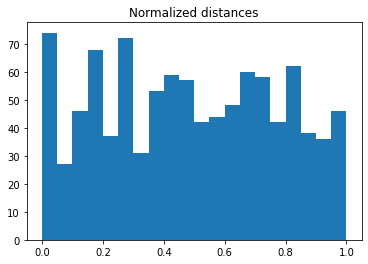

In [2]:
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 17.5]

# display(df.describe())

train_df = pd.DataFrame(df.iloc[:1000, :])
# normalized distance
train_df["Normalized distances"] = (train_df["Road distances [km]"] - train_df["Road distances [km]"].min()) / (train_df["Road distances [km]"].max() - train_df["Road distances [km]"].min())
# train_df = train_df[train_df["Mean speed"] < 1.7]
plt.hist(train_df["Normalized distances"], bins=20)
plt.title("Normalized distances")
plt.show()
# display(train_df["Road_traffic_density"].value_counts())
# plt.title("Count of density type")
# plt.show()

# train_df["Mean speed"].describe()
# train_df["Time_taken(min)"].describe()
# train_df.head()

road_density_map = {'Jam ':1, 'High ':2, 'Medium ':3, 'Low ':4}

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].apply(lambda x: road_density_map[x])


# PPC CHECKS

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


count    1000.000000
mean        1.879422
std         0.593195
min         0.719856
25%         1.380720
50%         1.882990
75%         2.384635
max         3.001520
Name: 0, dtype: float64

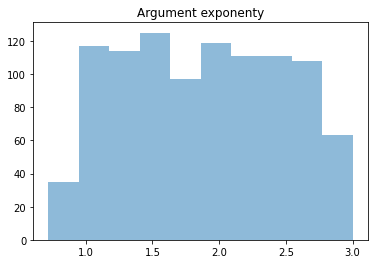

count    1000.000000
mean        7.768166
std         4.511996
min         2.054140
25%         3.977770
50%         6.573160
75%        10.855150
max        20.116100
Name: 0, dtype: float64

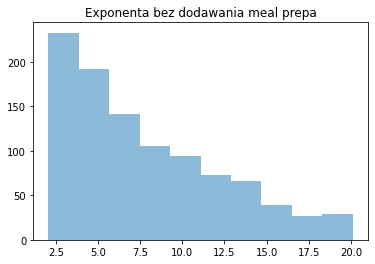

count    1000.000000
mean       23.703912
std        18.006057
min         3.589080
25%        11.069450
50%        17.995550
75%        31.028275
max        95.552300
Name: 0, dtype: float64

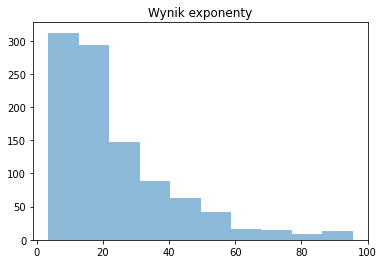

Odchylenie =  [[1.54846]]


count    1000.000000
mean      369.419398
std       599.884988
min         5.372350
25%        51.103400
50%       135.061000
75%       401.527250
max      3807.860000
Name: 0, dtype: float64

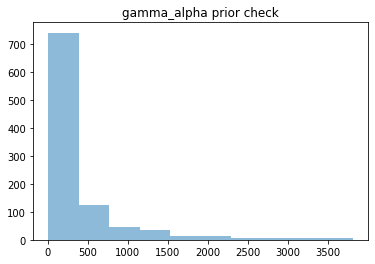

count    1000.000000
mean        9.885964
std         7.509615
min         1.496860
25%         4.616623
50%         7.505250
75%        12.940675
max        39.851100
Name: 0, dtype: float64

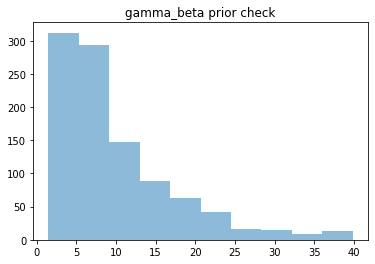

count    1000.000000
mean       23.711499
std        18.087611
min         1.670490
25%        10.867075
50%        18.235350
75%        31.088550
max        96.943600
Name: 0, dtype: float64


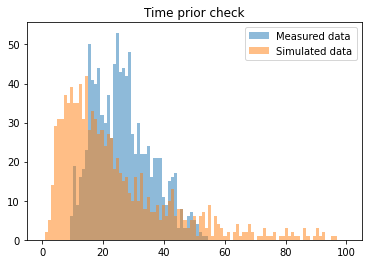

distance_coef    distance_coeff
0        0.127082


In [3]:
model_ppc=CmdStanModel(stan_file='basic_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values,"traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=29042020)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

# speed_bins = np.linspace(0,2.5,100)
# speed = ppc_df.filter(regex="speed.*")
# plt.hist(train_df["Mean speed"],bins=speed_bins ,alpha=0.5, label="Measured data")
# plt.hist(speed.values.flatten(),bins=speed_bins, alpha=0.5, label="Simulated data")
# plt.title("Speed prior check")
# plt.legend()
# plt.show()

mean_for_gamma = ppc_df.filter(regex="temp1.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Argument exponenty")
plt.show()

mean_for_gamma = ppc_df.filter(regex="temp2.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Exponenta bez dodawania meal prepa")
plt.show()

mean_for_gamma1 = ppc_df.filter(regex="mu.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma1.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma1.values.flatten(), alpha=0.5, label="Mu")
plt.title("Wynik exponenty")
plt.show()

sigma = ppc_df.filter(regex="sigma.*")
print(f"Odchylenie =  {sigma.values}")

mean_for_gamma2 = ppc_df.filter(regex="gamma_alpha.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma2.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma2.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_alpha prior check")
plt.show()

mean_for_gamma3 = ppc_df.filter(regex="gamma_beta.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma3.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma3.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_beta prior check")
plt.show()

print(delivery.iloc[0,:].describe())
plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data")
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("Time prior check")
plt.legend()
plt.show()


print(f"distance_coef {ppc_df.filter(regex='distance_coeff.*')}")


In [4]:
data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values,"traffic_level" :train_df["Road_traffic_density"].values}

display(train_df["Road distances [km]"].describe())
display(train_df["Meal_preparation_time"].describe())
display(train_df["Road_traffic_density"].value_counts())

count    1000.000000
mean        9.305281
std         4.524166
min         1.572000
25%         5.525500
50%         9.228000
75%        13.171000
max        17.433000
Name: Road distances [km], dtype: float64

count    1000.000000
mean        9.800000
std         4.071434
min         5.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        15.000000
Name: Meal_preparation_time, dtype: float64

4    343
1    324
3    234
2     99
Name: Road_traffic_density, dtype: int64

## Model fit

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |███▎      | 00:00 Status


chain 1 |██████▋   | 00:00 Iteration:  1 / 100 [  1%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                    
chain 2 |██████████| 00:00 Sampling completed                    
chain 3 |██████████| 00:00 Sampling completed                    
chain 4 |██████████| 00:00 Sampling completed                    


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,distance_coeff_raw,traffic_level_coeff[1],traffic_level_coeff[2],traffic_level_coeff[3],traffic_level_coeff[4],meal_prep_coeff,sigma,distance_coeff,...,exp_argument[991],exp_argument[992],exp_argument[993],exp_argument[994],exp_argument[995],exp_argument[996],exp_argument[997],exp_argument[998],exp_argument[999],exp_argument[1000]
0,0.0,0.0,-0.063851,0.069542,0.032588,0.084294,0.026439,0.068354,0.422528,0.063851,...,0.647191,1.43289,0.503379,1.64502,1.00676,0.962274,1.02791,0.5574,2.11039,0.879056
1,0.0,0.0,-0.063851,0.069542,0.032588,0.084294,0.026439,0.068354,0.422528,0.063851,...,0.647191,1.43289,0.503379,1.64502,1.00676,0.962274,1.02791,0.5574,2.11039,0.879056
2,0.0,0.0,-0.063851,0.069542,0.032588,0.084294,0.026439,0.068354,0.422528,0.063851,...,0.647191,1.43289,0.503379,1.64502,1.00676,0.962274,1.02791,0.5574,2.11039,0.879056
3,0.0,0.0,-0.063851,0.069542,0.032588,0.084294,0.026439,0.068354,0.422528,0.063851,...,0.647191,1.43289,0.503379,1.64502,1.00676,0.962274,1.02791,0.5574,2.11039,0.879056
4,0.0,0.0,-0.063851,0.069542,0.032588,0.084294,0.026439,0.068354,0.422528,0.063851,...,0.647191,1.43289,0.503379,1.64502,1.00676,0.962274,1.02791,0.5574,2.11039,0.879056


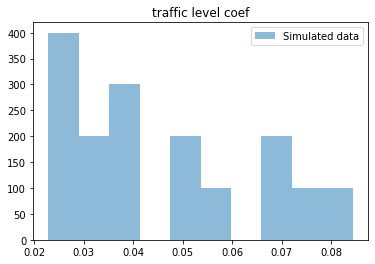

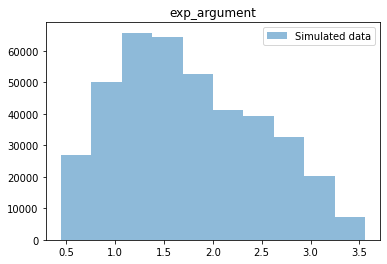

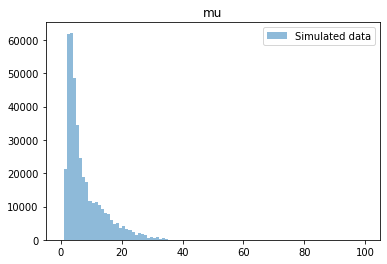

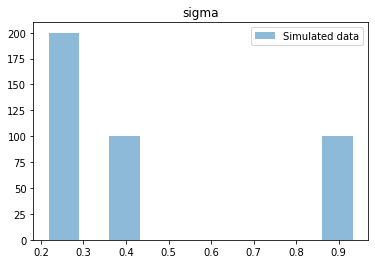

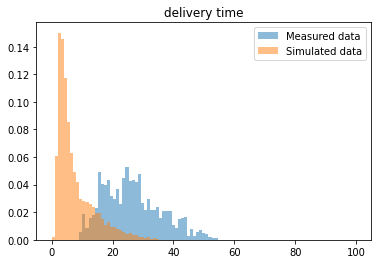

In [5]:
basic_fit=CmdStanModel(stan_file='basic_fit.stan')

basic_sample=basic_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Road distances [km]"].values,
                                    "meal_preparation_time": train_df["Meal_preparation_time"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values},
                              iter_sampling=100,
                              chains=4,
                              iter_warmup=0,
                              fixed_param=True,
                         )


df_fit = basic_sample.draws_pd()
display(df_fit.head())


traffib_level = df_fit.filter(regex="traffic_level_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("traffic level coef")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument")
plt.legend()
plt.show()

mu = df_fit.filter(regex="mu.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(mu.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("mu")
plt.legend()
plt.show()

# travel_time = df_fit.filter(regex="travel_time.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(travel_time.values.flatten(),bins=np.linspace(0,100,100), alpha=0.5, label="Simulated data")
# plt.title("travel time")
# plt.legend()
# plt.show()

sigma = df_fit.filter(regex="sigma.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(sigma.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("sigma")
plt.legend()
plt.show()



delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# print(f"meal_prep_ceof {df_fit.filter(regex='meal_prep_coef.*')}")
# print(f"distance_coef {df_fit.filter(regex='distance_coeff.*')}")

# PPC AND FIT WITH NORMALIZED DISTANCES

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


count    1000.000000
mean       16.370201
std         5.995674
min         7.635350
25%         9.937188
50%        16.558850
75%        23.073025
max        25.747700
Name: 0, dtype: float64

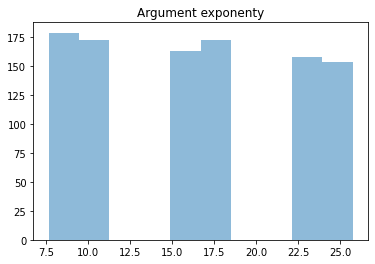

count    1000.000000
mean       11.699967
std        10.343510
min         1.351410
25%         3.912760
50%         8.418400
75%        15.863025
max        49.415300
Name: 0, dtype: float64

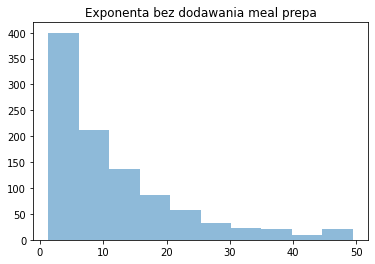

count    1000.000000
mean       25.979955
std        11.922069
min         8.704270
25%        17.334075
50%        24.544400
75%        31.697225
max        70.795500
Name: 0, dtype: float64

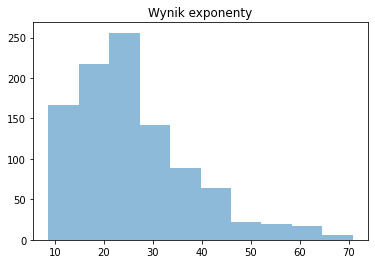

Odchylenie =  [[0.0892689]]


count      1000.000000
mean     102517.025840
std       98857.179051
min        9507.450000
25%       37705.150000
50%       75596.800000
75%      126079.000000
max      628943.000000
Name: 0, dtype: float64

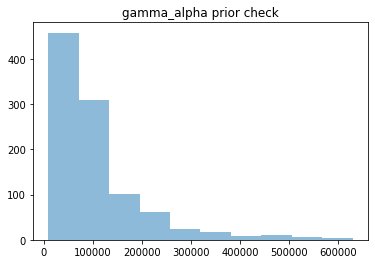

count    1000.000000
mean     3260.153500
std      1496.068049
min      1092.270000
25%      2175.202500
50%      3080.005000
75%      3977.595000
max      8883.940000
Name: 0, dtype: float64

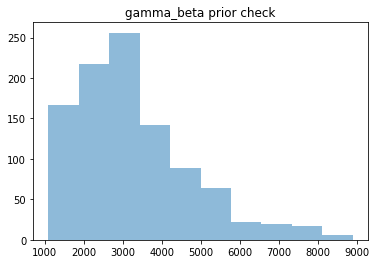

count    1000.000000
mean       25.982481
std        11.922973
min         8.656330
25%        17.305500
50%        24.567700
75%        31.684900
max        70.795700
Name: 0, dtype: float64


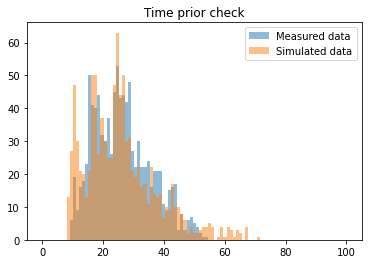

distance_coef    distance_coeff
0         2.79691


In [6]:
model_ppc=CmdStanModel(stan_file='norm_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Meal_preparation_time"].values,
                           "traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

mean_for_gamma = ppc_df.filter(regex="temp1.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Argument exponenty")
plt.show()

mean_for_gamma = ppc_df.filter(regex="temp2.*")

delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
plt.title("Exponenta bez dodawania meal prepa")
plt.show()

mean_for_gamma1 = ppc_df.filter(regex="mu.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma1.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma1.values.flatten(), alpha=0.5, label="Mu")
plt.title("Wynik exponenty")
plt.show()

sigma = ppc_df.filter(regex="sigma.*")
print(f"Odchylenie =  {sigma.values}")

mean_for_gamma2 = ppc_df.filter(regex="gamma_alpha.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma2.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma2.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_alpha prior check")
plt.show()

mean_for_gamma3 = ppc_df.filter(regex="gamma_beta.*")
# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma3.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma3.values.flatten(), alpha=0.5, label="Mu")
plt.title("gamma_beta prior check")
plt.show()

print(delivery.iloc[0,:].describe())
plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data")
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("Time prior check")
plt.legend()
plt.show()


print(f"distance_coef {ppc_df.filter(regex='distance_coeff.*')}")

INFO:cmdstanpy:compiling stan file /home/project_repo/data_analytics_project/norm_fit.stan to exe file /home/project_repo/data_analytics_project/norm_fit
INFO:cmdstanpy:compiled model executable: /home/project_repo/data_analytics_project/norm_fit
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 4


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,distance_coeff_raw,traffic_level_coeff[1],traffic_level_coeff[2],...,exp_argument_withMeal[991],exp_argument_withMeal[992],exp_argument_withMeal[993],exp_argument_withMeal[994],exp_argument_withMeal[995],exp_argument_withMeal[996],exp_argument_withMeal[997],exp_argument_withMeal[998],exp_argument_withMeal[999],exp_argument_withMeal[1000]
0,-6541.80,0.924682,0.431455,3.0,15.0,0.0,6544.85,1.34156,0.704141,0.458648,...,5.70144,11.2728,5.47986,11.5848,10.9359,6.08776,6.17471,5.77903,16.7318,10.7667
1,-6539.47,0.985037,0.431455,4.0,15.0,0.0,6545.80,1.50131,0.448307,0.625922,...,5.92150,11.3207,5.40944,11.9340,10.7554,6.08972,6.18703,5.55600,16.8583,10.5661
2,-6541.42,0.887198,0.431455,3.0,15.0,0.0,6543.44,1.42801,0.519282,0.378592,...,5.62650,11.2641,5.43066,11.5563,10.7449,6.07772,6.17027,5.58848,16.7423,10.5649
3,-6541.81,0.871666,0.431455,3.0,15.0,0.0,6545.94,1.41803,0.645086,0.625995,...,5.87573,11.2851,5.45386,11.8026,10.8763,6.09640,6.18831,5.71736,16.7634,10.6975
4,-6540.52,0.982138,0.431455,3.0,7.0,0.0,6544.16,1.46369,0.523973,0.600500,...,5.90837,11.2968,5.38870,11.9152,10.8628,6.05193,6.14680,5.64866,16.8406,10.6782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-6542.06,0.905532,0.386726,3.0,15.0,0.0,6548.12,1.37923,0.432788,0.616638,...,5.85606,11.2800,5.47504,11.7541,10.6507,6.10000,6.18939,5.49960,16.7418,10.4768
3996,-6539.74,1.000000,0.386726,3.0,7.0,0.0,6543.44,1.50834,0.547636,0.462178,...,5.75475,11.2983,5.38726,11.7676,10.8474,6.07072,6.16848,5.65144,16.8341,10.6572
3997,-6540.74,0.948083,0.386726,4.0,15.0,0.0,6542.29,1.44730,0.606652,0.752046,...,6.00152,11.3222,5.47921,11.9421,10.8318,6.13502,6.22882,5.67499,16.8050,10.6493
3998,-6539.93,0.987429,0.386726,4.0,15.0,0.0,6542.82,1.52431,0.565463,0.471737,...,5.80349,11.4574,5.50058,11.8631,10.9406,6.19128,6.29008,5.70645,17.0349,10.7484


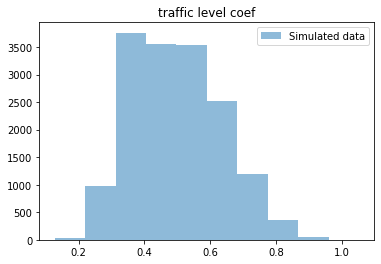

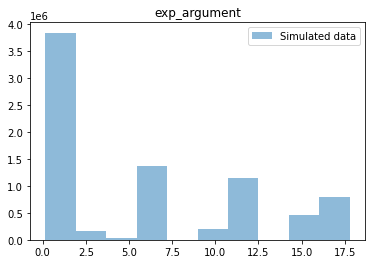

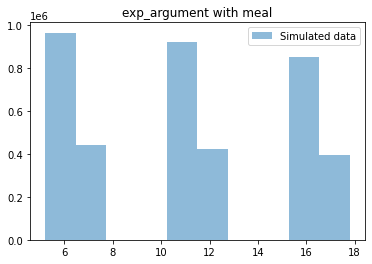

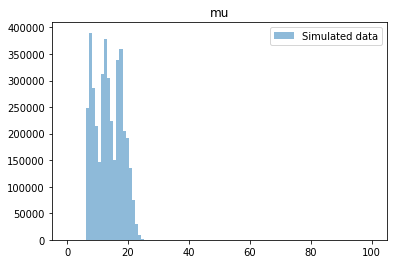

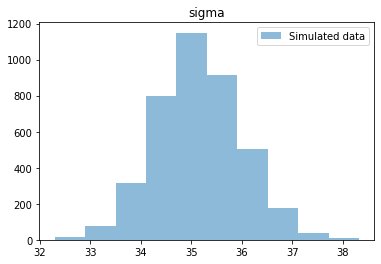

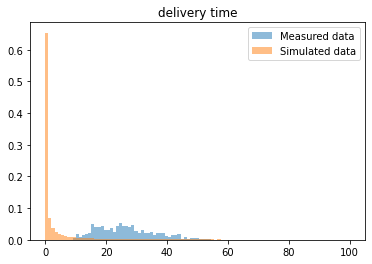

In [14]:
basic_fit=CmdStanModel(stan_file='norm_fit.stan')

basic_sample=basic_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Normalized distances"].values,
                                    "meal_preparation_time": train_df["Meal_preparation_time"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values},
                     iter_sampling=1000,
                     iter_warmup=1000, 
                     chains=4,
                         )


df_fit = basic_sample.draws_pd()
display(df_fit)


traffib_level = df_fit.filter(regex="traffic_level_coef.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("traffic level coef")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument")
plt.legend()
plt.show()

epx_argument = df_fit.filter(regex="exp_argument_with.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("exp_argument with meal")
plt.legend()
plt.show()

mu = df_fit.filter(regex="mu.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(mu.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("mu")
plt.legend()
plt.show()

# travel_time = df_fit.filter(regex="travel_time.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(travel_time.values.flatten(),bins=np.linspace(0,100,100), alpha=0.5, label="Simulated data")
# plt.title("travel time")
# plt.legend()
# plt.show()

sigma = df_fit.filter(regex="sigma.*")
# df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(sigma.values.flatten(), alpha=0.5, label="Simulated data")
plt.title("sigma")
plt.legend()
plt.show()



delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# print(f"meal_prep_ceof {df_fit.filter(regex='meal_prep_coef.*')}")
# print(f"distance_coef {df_fit.filter(regex='distance_coeff.*')}")

In [15]:
temp=basic_sample.diagnose()
with open("output.txt", "w") as file:
    file.write(temp)

In [9]:

display(mu.values.flatten().min())

9.41413